<a href="https://colab.research.google.com/github/Arju-cmd/NLP_Models/blob/main/BERT_Classify_spam_vs_no_spam_emails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 8.1 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [8]:
import pandas as pd

df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [12]:
df.rename(columns={'v1':'Category', 'v2':'Message'  }, inplace=True)

In [14]:
df = df[['Category','Message']]

In [15]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [16]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    653  Please call our customer service representativ...    4

In [17]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [18]:
# 15% spam emails, 85% ham emails: This indicates class imbalance

In [19]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [20]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [21]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [22]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [23]:
df_balanced['Category'].value_counts()


ham     747
spam    747
Name: Category, dtype: int64

In [24]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3062,spam,"Hi babe its Jordan, how r u? Im home from abro...",1
935,ham,Then dun wear jeans lor...,0
4982,ham,Networking job is there.,0
3482,ham,"Hello, my love! How goes that day ? I wish you...",0
468,ham,"Yup, no need. I'll jus wait 4 e rain 2 stop.",0


In [25]:
# Split it into training and test data set

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [27]:
X_train.head(4)

2818    Don't forget who owns you and who's private pr...
3354                        Minimum walk is 3miles a day.
2789          When you are big..| God will bring success.
1224    You are a winner U have been specially selecte...
Name: Message, dtype: object

In [28]:
 # import BERT model and get embeding vectors for few sample statements

In [29]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [30]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.88845736, ..., -0.74748856,
        -0.7531474 ,  0.91964495],
       [-0.8720837 , -0.5054399 , -0.94446677, ..., -0.8584751 ,
        -0.71745366,  0.88082993]], dtype=float32)>

In [31]:
# Get embeding vectors for few sample words. Compare them using cosine similarity

In [32]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

In [34]:
# Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [35]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

In [37]:
# Jeff bezos and Elon musk are more similar

In [38]:
# Build Model
# There are two types of models you can build in tensorflow.

# (1) Sequential (2) Functional
# we will build functional model

In [39]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [41]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [42]:
# Train the model

In [43]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 491s 14s/step - loss: 0.6345 - accuracy: 0.6518 - precision: 0.6403 - recall: 0.6929
Epoch 2/10
35/35 [==============================] - 481s 14s/step - loss: 0.5023 - accuracy: 0.8259 - precision: 0.8027 - recall: 0.8643
Epoch 3/10
35/35 [==============================] - 480s 14s/step - loss: 0.4354 - accuracy: 0.8589 - precision: 0.8466 - recall: 0.8768
Epoch 4/10
35/35 [==============================] - 479s 14s/step - loss: 0.3915 - accuracy: 0.8670 - precision: 0.8477 - recall: 0.8946
Epoch 5/10
35/35 [==============================] - 479s 14s/step - loss: 0.3545 - accuracy: 0.8884 - precision: 0.8822 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 478s 14s/step - loss: 0.3340 - accuracy: 0.8893 - precision: 0.8798 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 479s 14s/step - loss: 0.3060 - accuracy: 0.9000 - precision: 0.8836 - recall: 0.9214
Epoch 8/10
35/35 [=======================

In [44]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 161s 13s/step - loss: 0.2815 - accuracy: 0.8957 - precision: 0.8737 - recall: 0.9251


[0.28148457407951355,
 0.8957219123840332,
 0.8737373948097229,
 0.9251337051391602]

In [45]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [46]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,

In [47]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[162,  25],
       [ 14, 173]])

Text(33.0, 0.5, 'Truth')

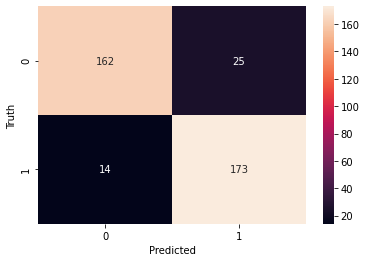

In [48]:

from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       187
           1       0.87      0.93      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [50]:
# Inference

In [51]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.78584874],
       [0.8341361 ],
       [0.7718245 ],
       [0.20782012],
       [0.08085778]], dtype=float32)